# Installing libraries

In [ ]:
!pip install -r https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/SafeRide_Dtection/refs/heads/main/requirements.txt

Ignoring colorama: markers 'python_version >= "3.11" and python_version < "4.0" and platform_system == "Windows"' don't match your environment
Ignoring pywin32: markers 'python_version >= "3.11" and python_version < "4.0" and sys_platform == "win32"' don't match your environment
Ignoring waitress: markers 'python_version >= "3.11" and python_version < "4.0" and platform_system == "Windows"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━

# Uploading kaggle Auth Key

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashsethi24","key":"edbf0036ebd673985f86ae4176a42b53"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading dataset from Kaggle

In [ ]:
!kaggle datasets download -d andrewmvd/helmet-detection
!unzip helmet-detection.zip -d helmet_data

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/helmet-detection
License(s): CC0-1.0
Archive:  helmet-detection.zip
  inflating: helmet_data/annotations/BikesHelmets0.xml  
  inflating: helmet_data/annotations/BikesHelmets1.xml  
  inflating: helmet_data/annotations/BikesHelmets10.xml  
  inflating: helmet_data/annotations/BikesHelmets100.xml  
  inflating: helmet_data/annotations/BikesHelmets101.xml  
  inflating: helmet_data/annotations/BikesHelmets102.xml  
  inflating: helmet_data/annotations/BikesHelmets103.xml  
  inflating: helmet_data/annotations/BikesHelmets104.xml  
  inflating: helmet_data/annotations/BikesHelmets105.xml  
  inflating: helmet_data/annotations/BikesHelmets106.xml  
  inflating: helmet_data/annotations/BikesHelmets107.xml  
  inflating: helmet_data/annotations/BikesHelmets108.xml  
  inflating: helmet_data/annotations/BikesHelmets109.xml  
  inflating: helmet_data/annotations/BikesHelmets11.xml  
  inflating: helmet_data/annotations/BikesHelmets110.xml 

# Preparing dataset for training and testing

In [ ]:
import os
import random
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# Paths
base_path = '/content/helmet_data'
images_path = os.path.join(base_path, 'images')
annotations_path = os.path.join(base_path, 'annotations')
output_path = '/content/helmet_data_split'  # New base folder

# Make sure output folders exist
for split in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

# Step 1: Find all images that have corresponding annotations
image_files = [f for f in os.listdir(images_path) if f.endswith('.png')]
annotation_files = [f.replace('.xml', '') for f in os.listdir(annotations_path) if f.endswith('.xml')]

# Keep only images that have annotation
valid_images = [f for f in image_files if f.replace('.png', '') in annotation_files]

print(f"Total valid images with annotations: {len(valid_images)}")

# Step 2: Split into train, val, test
train_imgs, temp_imgs = train_test_split(valid_images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

splits = {'train': train_imgs, 'valid': val_imgs, 'test': test_imgs}

# Helper: XML to YOLO TXT converter
def convert_annotation(xml_file, txt_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    with open(txt_file, 'w') as f:
        for obj in root.findall('object'):
            cls = obj.find('name').text
            # Assuming 'helmet' is class 0, you can modify if multiple classes
            cls_id = 0
            xmlbox = obj.find('bndbox')
            xmin = int(xmlbox.find('xmin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymin = int(xmlbox.find('ymin').text)
            ymax = int(xmlbox.find('ymax').text)

            # Convert to YOLO format
            x_center = (xmin + xmax) / 2 / width
            y_center = (ymin + ymax) / 2 / height
            w = (xmax - xmin) / width
            h = (ymax - ymin) / height

            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

# Step 3: Move and convert
for split_name, img_list in splits.items():
    for img_file in img_list:
        img_src = os.path.join(images_path, img_file)
        img_dst = os.path.join(output_path, split_name, 'images', img_file)
        shutil.copy(img_src, img_dst)

        # Convert annotation
        xml_file = os.path.join(annotations_path, img_file.replace('.png', '.xml'))
        txt_file = os.path.join(output_path, split_name, 'labels', img_file.replace('.png', '.txt'))
        convert_annotation(xml_file, txt_file)

print("✅ Dataset prepared successfully!")

Total valid images with annotations: 764
✅ Dataset prepared successfully!


In [ ]:
import os

# Base output path
output_path = '/content/helmet_data_split'

# Folders to check
splits = ['train', 'valid', 'test']

for split in splits:
    images_dir = os.path.join(output_path, split, 'images')
    labels_dir = os.path.join(output_path, split, 'labels')

    num_images = len([f for f in os.listdir(images_dir) if f.endswith('.png')])
    num_labels = len([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

    print(f"{split.upper()}: {num_images} images, {num_labels} labels")


TRAIN: 534 images, 534 labels
VALID: 154 images, 154 labels
TEST: 76 images, 76 labels


# Creating YAML file for YOLO

In [ ]:
dataset_yaml = """
path: ../helmet_data_split
train: train/images
val: valid/images
test: test/images

names:
  0: With Helmet
"""

with open('/content/helmet_data_split/dataset.yaml', 'w') as f:
    f.write(dataset_yaml)

print("✅ Correct dataset.yaml created!")


✅ Correct dataset.yaml created!


# Running Experiments using MLFlow

# ---------------- Training Description ----------------
"""
📌 TRAINING CONFIGURATION: HELMET DETECTION USING YOLOv8 + MLFLOW

✅ MODELS USED:
- YOLOv8s (small), YOLOv8m (medium), YOLOv8l (large)
- All models are initialized from Ultralytics pre-trained checkpoints (.pt files)

🖼️ IMAGE SIZES:
- Trained on 3 resolutions: 640x640, 800x800, 960x960

📊 HYPERPARAMETERS:
- Epochs: 20
- Batch size: 16
- Optimizer: SGD
- Learning rate: 0.001 → 0.1 (final fraction via cosine decay)
- Momentum: 0.937
- Weight decay: 0.0005
- Patience (early stopping): 20 epochs
- Workers: 4

🧪 DATA AUGMENTATION STRATEGIES:
- mosaic=0.3: Merges 4 images to increase scene complexity
- mixup=0.1: Combines 2 images and labels for smoother decision boundaries
- hsv_h=0.01, hsv_s=0.3, hsv_v=0.2: Color augmentation in hue, saturation, brightness
- fliplr=0.3: Random horizontal flip
- flipud=0.0: No vertical flipping
- degrees=3.0: Small image rotations
- translate=0.05: Shifts image up to 5% in any direction
- scale=0.1: Random zoom-in/zoom-out
- shear=0.05: Diagonal image distortion
- perspective=0.0: No perspective change

📁 DATASET:
- Defined in dataset.yaml (YOLO format)
- Loaded from: /content/helmet_data_split/dataset.yaml
- Binary classification: Helmet detection

🧠 MLFLOW LOGGING:
- Logs all hyperparameters and metrics:
    - val/precision, val/recall, mAP@0.5, mAP@0.5:0.95
    - inference/postprocess speed (ms)
- Artifacts logged: best.pt (best model weights)
- Each run named using model, image size, and epoch combo

📍 SAVE DIRECTORY:
- Training outputs stored under: /content/yolo_runs/

"""
# ------------------------------------------------------


In [ ]:
import os
import mlflow
from ultralytics import YOLO
from itertools import product

# --------------- MLflow Setup ----------------
# Reset tracking
mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("Helmet Detection YOLO")

# --------------- Experiment Settings ----------------
model_types = ['yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt']  # Models
img_sizes = [640, 800, 960]  # Image Sizes
epochs_list = [20]  # Epochs

# Other fixed training parameters
data_path = '/content/helmet_data_split/dataset.yaml'  # Your dataset YAML
save_dir = '/content/yolo_runs'  # Output directory

# --------------- Training Loop ----------------
for model_type, imgsz, epochs in product(model_types, img_sizes, epochs_list):
    run_name = f"{model_type.replace('.pt','')}_imgsz{imgsz}_ep{epochs}"

    try:
        with mlflow.start_run(run_name=run_name):
            # Initialize model
            model = YOLO(model_type)

            # Train
            results = model.train(
                data=data_path,
                epochs=epochs,
                imgsz=imgsz,
                save=True,
                project=save_dir,
                name=run_name,
                batch=16,
                device=0,  # GPU 0
                workers=4,
                optimizer='SGD',
                lr0=0.001,
                lrf=0.1,
                weight_decay=0.0005,
                momentum=0.937,
                patience=20,
                cache=True,
                save_period=10,
                exist_ok=True,
                augment=True,
                conf=0.5,
                iou=0.5,
                mosaic=0.3,
                mixup=0.1,
                hsv_h=0.01,
                hsv_s=0.3,
                hsv_v=0.2,
                flipud=0.0,
                fliplr=0.3,
                degrees=3.0,
                translate=0.05,
                scale=0.1,
                shear=0.05,
                perspective=0.0,
                amp=True,
                agnostic_nms=False
            )

            # --------- MLflow Logging ---------
            # Log Params
            mlflow.log_param("model_type", model_type)
            mlflow.log_param("imgsz", imgsz)
            mlflow.log_param("epochs", epochs)

            # Log Metrics
            if results:
                mlflow.log_metric("val/precision", results.box.p[0] if results.box.p is not None else 0)
                mlflow.log_metric("val/recall", results.box.r[0] if results.box.r is not None else 0)
                mlflow.log_metric("val/mAP50", results.box.map50 if results.box.map50 is not None else 0)
                mlflow.log_metric("val/mAP50-95", results.box.map if results.box.map is not None else 0)
                mlflow.log_metric("speed_inference_ms", results.speed['inference'])
                mlflow.log_metric("speed_postprocess_ms", results.speed['postprocess'])

            # Log Best Model Artifact
            best_model_path = os.path.join(save_dir, run_name, 'weights', 'best.pt')
            if os.path.exists(best_model_path):
                mlflow.log_artifact(best_model_path)

    finally:
        # Always end run cleanly even if error happens
        mlflow.end_run()

print("🎯 All experiments completed and logged to MLflow!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


2025/04/27 08:24:22 INFO mlflow.tracking.fluent: Experiment with name 'Helmet Detection YOLO' does not exist. Creating a new experiment.


100%|██████████| 21.5M/21.5M [00:00<00:00, 249MB/s]


Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/helmet_data_split/dataset.yaml, epochs=20, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8s_imgsz640_ep20, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=0.5, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 21.4MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

Model summary: 129 layers, 11,135,987 parameters, 11,135,971 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 113MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1644.2±981.5 MB/s, size: 499.9 KB)


train: Scanning /content/helmet_data_split/train/labels... 534 images, 2 backgrounds, 7 corrupt: 100%|██████████| 534/534 [00:00<00:00, 896.90it/s]

train: /content/helmet_data_split/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [263.5  43.   85.   74. ]
train: /content/helmet_data_split/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [194.5  56.  103.  100. ]
train: /content/helmet_data_split/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [157.   56.5  86.   97. ]
train: /content/helmet_data_split/train/images/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [310.5  41.5  61.   63. ]
train: /content/helmet_data_split/train/images/BikesHelmets444.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [299.  48.  78.  80.]
train: /content/helmet_data_split/train/images/BikesHelmets446.png: 1 duplicate labels removed
train: /content/helmet_data_split/train/images/BikesHelmets764.png: i

train: New cache created: /content/helmet_data_split/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.4GB RAM): 100%|██████████| 527/527 [00:07<00:00, 69.16it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1957.6±1667.8 MB/s, size: 530.8 KB)


val: Scanning /content/helmet_data_split/valid/labels... 154 images, 0 backgrounds, 5 corrupt: 100%|██████████| 154/154 [00:00<00:00, 376.85it/s]

val: /content/helmet_data_split/valid/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [547.685  84.5   132.165 151.   ]
val: /content/helmet_data_split/valid/images/BikesHelmets530.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [313.3525  74.     102.115  116.    ]
val: /content/helmet_data_split/valid/images/BikesHelmets616.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [750.  297.5  68.   91. ]
val: /content/helmet_data_split/valid/images/BikesHelmets671.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [863. 251.  52.  52.]
val: /content/helmet_data_split/valid/images/BikesHelmets75.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [471.  290.5  82.  109.  761.  291.5  84.   97.  466.5 297.  109.  118. ]
val: New cache created: /content/helmet_data_split/valid/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 149/149 [00:01<00:00, 75.46it/s]


Plotting labels to /content/yolo_runs/yolov8s_imgsz640_ep20/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/04/27 08:24:45 INFO mlflow.tracking.fluent: Experiment with name '/content/yolo_runs' does not exist. Creating a new experiment.
2025/04/27 08:24:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/27 08:24:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/27 08:24:48 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/27 08:24:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(3a2a34fc268a496fac41d32a0760d05e) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8s_imgsz640_ep20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.58G      2.067      6.242      1.708         37        640: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        149        281       0.25    0.00712      0.126     0.0566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       4.3G      1.569      1.677      1.435         41        640: 100%|██████████| 33/33 [00:08<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        149        281      0.805      0.648      0.719      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.33G      1.326      1.014      1.242         30        640: 100%|██████████| 33/33 [00:08<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]

                   all        149        281      0.826       0.69      0.743        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.35G       1.28     0.8869      1.188         35        640: 100%|██████████| 33/33 [00:09<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

                   all        149        281      0.835       0.74      0.785      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.37G      1.296     0.8275      1.178         35        640: 100%|██████████| 33/33 [00:09<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        149        281      0.834      0.769      0.806      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       4.4G      1.242     0.7864      1.147         36        640: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


                   all        149        281      0.822      0.822      0.835      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.42G      1.191     0.7047      1.113         43        640: 100%|██████████| 33/33 [00:08<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


                   all        149        281       0.87      0.737      0.806      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.45G      1.168     0.6931      1.108         47        640: 100%|██████████| 33/33 [00:08<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]

                   all        149        281      0.836      0.833      0.852      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.47G      1.197     0.6649      1.117         26        640: 100%|██████████| 33/33 [00:08<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]

                   all        149        281      0.845      0.847      0.856      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       4.5G      1.139     0.6519      1.094         35        640: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

                   all        149        281      0.836      0.872       0.87      0.566


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.52G      1.109     0.5778      1.061         34        640: 100%|██████████| 33/33 [00:09<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]

                   all        149        281      0.867      0.815      0.856      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.55G      1.075     0.5486      1.049         38        640: 100%|██████████| 33/33 [00:09<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        149        281      0.855      0.861      0.869      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.57G      1.062     0.5384      1.037         23        640: 100%|██████████| 33/33 [00:08<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

                   all        149        281      0.873      0.833      0.852      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.59G      1.022      0.512      1.035         28        640: 100%|██████████| 33/33 [00:08<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

                   all        149        281      0.854      0.854      0.853      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.62G      1.029     0.5119      1.021         33        640: 100%|██████████| 33/33 [00:09<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]

                   all        149        281      0.873      0.829       0.86      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.64G      1.015     0.5022      1.017         20        640: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]

                   all        149        281      0.868      0.843      0.862      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.66G      1.001     0.4872      1.006         24        640: 100%|██████████| 33/33 [00:09<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

                   all        149        281      0.875      0.843      0.866      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.69G      0.975      0.479     0.9959         31        640: 100%|██████████| 33/33 [00:08<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        149        281      0.871      0.865      0.873      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.71G     0.9606     0.4682      1.009         29        640: 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

                   all        149        281      0.855      0.861      0.866      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.74G     0.9624     0.4627      1.002         32        640: 100%|██████████| 33/33 [00:08<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]

                   all        149        281      0.865      0.865      0.874       0.57



20 epochs completed in 0.060 hours.
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz640_ep20/weights/last.pt, 22.5MB
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz640_ep20/weights/best.pt, 22.5MB

Validating /content/yolo_runs/yolov8s_imgsz640_ep20/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


                   all        149        281      0.846      0.879      0.887      0.574
Speed: 0.2ms preprocess, 23.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/yolo_runs/yolov8s_imgsz640_ep20
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/helmet_data_split/dataset.yaml, epochs=20, time=None, patience=20, batch=16, imgsz=800, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8s_imgsz800_ep20, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json

train: Scanning /content/helmet_data_split/train/labels.cache... 534 images, 2 backgrounds, 7 corrupt: 100%|██████████| 534/534 [00:00<?, ?it/s]

train: /content/helmet_data_split/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [263.5  43.   85.   74. ]
train: /content/helmet_data_split/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [194.5  56.  103.  100. ]
train: /content/helmet_data_split/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [157.   56.5  86.   97. ]
train: /content/helmet_data_split/train/images/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [310.5  41.5  61.   63. ]
train: /content/helmet_data_split/train/images/BikesHelmets444.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [299.  48.  78.  80.]
train: /content/helmet_data_split/train/images/BikesHelmets446.png: 1 duplicate labels removed
train: /content/helmet_data_split/train/images/BikesHelmets764.png: i

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.6GB RAM): 100%|██████████| 527/527 [00:08<00:00, 65.65it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1053.8±993.7 MB/s, size: 530.8 KB)


val: Scanning /content/helmet_data_split/valid/labels.cache... 154 images, 0 backgrounds, 5 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]

val: /content/helmet_data_split/valid/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [547.685  84.5   132.165 151.   ]
val: /content/helmet_data_split/valid/images/BikesHelmets530.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [313.3525  74.     102.115  116.    ]
val: /content/helmet_data_split/valid/images/BikesHelmets616.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [750.  297.5  68.   91. ]
val: /content/helmet_data_split/valid/images/BikesHelmets671.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [863. 251.  52.  52.]
val: /content/helmet_data_split/valid/images/BikesHelmets75.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [471.  290.5  82.  109.  761.  291.5  84.   97.  466.5 297.  109.  118. ]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.2GB RAM): 100%|██████████| 149/149 [00:02<00:00, 60.47it/s]


Plotting labels to /content/yolo_runs/yolov8s_imgsz800_ep20/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/04/27 08:28:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/27 08:28:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/27 08:28:48 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/27 08:28:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(7b37c667099d4085b043846d26e0ae31) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8s_imgsz800_ep20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       5.5G      2.039      7.481      1.786         37        800: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]

                   all        149        281      0.625     0.0178      0.318      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.59G      1.604      1.807      1.526         41        800: 100%|██████████| 33/33 [00:14<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        149        281      0.825      0.569      0.686      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.59G      1.342       1.05      1.326         30        800: 100%|██████████| 33/33 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

                   all        149        281      0.786      0.786      0.761      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.59G      1.287     0.9019      1.253         35        800: 100%|██████████| 33/33 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        149        281      0.793      0.843      0.822      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.59G      1.294     0.8472       1.25         35        800: 100%|██████████| 33/33 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        149        281      0.802      0.822      0.836      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.59G      1.248     0.7973      1.227         36        800: 100%|██████████| 33/33 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        149        281      0.819      0.786      0.819      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.59G      1.204     0.7211      1.194         43        800: 100%|██████████| 33/33 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        149        281      0.908      0.594      0.748      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.59G       1.16      0.714      1.186         47        800: 100%|██████████| 33/33 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        149        281      0.873      0.712      0.803       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.59G      1.186     0.6832      1.185         26        800: 100%|██████████| 33/33 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        149        281      0.846      0.822      0.848      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.59G      1.141     0.6614      1.157         35        800: 100%|██████████| 33/33 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        149        281      0.835      0.847      0.861      0.562


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.59G      1.099     0.5754      1.118         34        800: 100%|██████████| 33/33 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        149        281      0.873      0.829      0.863      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.59G      1.076      0.551      1.113         38        800: 100%|██████████| 33/33 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        149        281      0.865      0.847      0.873       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.59G      1.067     0.5472        1.1         23        800: 100%|██████████| 33/33 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        149        281      0.846       0.84      0.855      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.59G      1.038     0.5152      1.095         28        800: 100%|██████████| 33/33 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

                   all        149        281      0.854      0.811      0.843      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.59G      1.021     0.5074      1.092         33        800: 100%|██████████| 33/33 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

                   all        149        281      0.875      0.797       0.85      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.59G      1.004      0.497      1.075         20        800: 100%|██████████| 33/33 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        149        281      0.853      0.843      0.865      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.59G     0.9939     0.4823      1.064         24        800: 100%|██████████| 33/33 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        149        281       0.86      0.833      0.862      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.59G     0.9744     0.4744      1.055         31        800: 100%|██████████| 33/33 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

                   all        149        281      0.846       0.84      0.866       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.59G     0.9646     0.4676      1.046         29        800: 100%|██████████| 33/33 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        149        281       0.87      0.808      0.853      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.59G     0.9593     0.4623      1.047         32        800: 100%|██████████| 33/33 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all        149        281      0.861       0.84      0.869      0.568



20 epochs completed in 0.088 hours.
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz800_ep20/weights/last.pt, 22.5MB
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz800_ep20/weights/best.pt, 22.5MB

Validating /content/yolo_runs/yolov8s_imgsz800_ep20/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


                   all        149        281       0.84      0.861      0.872      0.572
Speed: 0.5ms preprocess, 21.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/yolo_runs/yolov8s_imgsz800_ep20
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/helmet_data_split/dataset.yaml, epochs=20, time=None, patience=20, batch=16, imgsz=960, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8s_imgsz960_ep20, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json

train: Scanning /content/helmet_data_split/train/labels.cache... 534 images, 2 backgrounds, 7 corrupt: 100%|██████████| 534/534 [00:00<?, ?it/s]

train: /content/helmet_data_split/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [263.5  43.   85.   74. ]
train: /content/helmet_data_split/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [194.5  56.  103.  100. ]
train: /content/helmet_data_split/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [157.   56.5  86.   97. ]
train: /content/helmet_data_split/train/images/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [310.5  41.5  61.   63. ]
train: /content/helmet_data_split/train/images/BikesHelmets444.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [299.  48.  78.  80.]
train: /content/helmet_data_split/train/images/BikesHelmets446.png: 1 duplicate labels removed
train: /content/helmet_data_split/train/images/BikesHelmets764.png: i

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.9GB RAM): 100%|██████████| 527/527 [00:07<00:00, 65.99it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 881.6±803.1 MB/s, size: 530.8 KB)


val: Scanning /content/helmet_data_split/valid/labels.cache... 154 images, 0 backgrounds, 5 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]

val: /content/helmet_data_split/valid/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [547.685  84.5   132.165 151.   ]
val: /content/helmet_data_split/valid/images/BikesHelmets530.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [313.3525  74.     102.115  116.    ]
val: /content/helmet_data_split/valid/images/BikesHelmets616.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [750.  297.5  68.   91. ]
val: /content/helmet_data_split/valid/images/BikesHelmets671.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [863. 251.  52.  52.]
val: /content/helmet_data_split/valid/images/BikesHelmets75.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [471.  290.5  82.  109.  761.  291.5  84.   97.  466.5 297.  109.  118. ]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.3GB RAM): 100%|██████████| 149/149 [00:03<00:00, 46.19it/s]


Plotting labels to /content/yolo_runs/yolov8s_imgsz960_ep20/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/04/27 08:34:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/27 08:34:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/27 08:34:32 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/27 08:34:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(eabda86336a64a858754dd85cdf3bddb) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8s_imgsz960_ep20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.01G      2.061      8.664      1.892         37        960: 100%|██████████| 33/33 [00:20<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        149        281          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.02G      1.632      1.961      1.608         41        960: 100%|██████████| 33/33 [00:20<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        149        281      0.828       0.53      0.646      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.93G      1.361      1.098      1.388         30        960: 100%|██████████| 33/33 [00:19<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all        149        281      0.812      0.737      0.756      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.94G      1.283     0.9234      1.333         35        960: 100%|██████████| 33/33 [00:18<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all        149        281      0.805      0.573      0.657       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.93G      1.305     0.8639      1.314         35        960: 100%|██████████| 33/33 [00:18<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

                   all        149        281      0.809      0.737      0.747      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.98G      1.249     0.8169      1.261         36        960: 100%|██████████| 33/33 [00:19<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        149        281      0.864      0.676      0.768      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.93G      1.207     0.7244      1.228         43        960: 100%|██████████| 33/33 [00:19<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        149        281      0.872       0.58      0.716      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.93G      1.177      0.732      1.236         47        960: 100%|██████████| 33/33 [00:19<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        149        281      0.876      0.705      0.783      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.93G      1.193     0.6846      1.227         26        960: 100%|██████████| 33/33 [00:18<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        149        281      0.827      0.851      0.846      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.03G      1.142     0.6743      1.197         35        960: 100%|██████████| 33/33 [00:19<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

                   all        149        281      0.847      0.865      0.859      0.569


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.94G      1.103     0.5854      1.152         34        960: 100%|██████████| 33/33 [00:20<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        149        281      0.843       0.84      0.859      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.94G      1.097     0.5525      1.152         38        960: 100%|██████████| 33/33 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        149        281      0.854      0.854       0.87      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.93G      1.066     0.5514      1.137         23        960: 100%|██████████| 33/33 [00:18<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        149        281      0.855      0.836      0.856      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.98G       1.04     0.5211      1.123         28        960: 100%|██████████| 33/33 [00:18<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

                   all        149        281      0.865      0.841      0.866      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.94G      1.032     0.5159      1.127         33        960: 100%|██████████| 33/33 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

                   all        149        281      0.871      0.819      0.859      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.93G      1.012     0.5108      1.131         20        960: 100%|██████████| 33/33 [00:18<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        149        281      0.835      0.847      0.866      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.93G      1.008     0.4872      1.112         24        960: 100%|██████████| 33/33 [00:18<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        149        281       0.87      0.804      0.855      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.98G      0.992     0.4833      1.105         31        960: 100%|██████████| 33/33 [00:18<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        149        281       0.86      0.851      0.872      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.93G     0.9666     0.4746      1.099         29        960: 100%|██████████| 33/33 [00:18<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        149        281      0.865      0.829      0.862      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.95G     0.9624     0.4647      1.077         32        960: 100%|██████████| 33/33 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        149        281      0.858       0.84      0.868      0.577



20 epochs completed in 0.122 hours.
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz960_ep20/weights/last.pt, 22.6MB
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz960_ep20/weights/best.pt, 22.6MB

Validating /content/yolo_runs/yolov8s_imgsz960_ep20/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


                   all        149        281      0.847      0.864      0.885      0.572
Speed: 0.4ms preprocess, 25.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/yolo_runs/yolov8s_imgsz960_ep20
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'


100%|██████████| 49.7M/49.7M [00:00<00:00, 254MB/s]


Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/helmet_data_split/dataset.yaml, epochs=20, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8m_imgsz640_ep20, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=0.5, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

train: Scanning /content/helmet_data_split/train/labels.cache... 534 images, 2 backgrounds, 7 corrupt: 100%|██████████| 534/534 [00:00<?, ?it/s]

train: /content/helmet_data_split/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [263.5  43.   85.   74. ]
train: /content/helmet_data_split/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [194.5  56.  103.  100. ]
train: /content/helmet_data_split/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [157.   56.5  86.   97. ]
train: /content/helmet_data_split/train/images/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [310.5  41.5  61.   63. ]
train: /content/helmet_data_split/train/images/BikesHelmets444.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [299.  48.  78.  80.]
train: /content/helmet_data_split/train/images/BikesHelmets446.png: 1 duplicate labels removed
train: /content/helmet_data_split/train/images/BikesHelmets764.png: i

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.4GB RAM): 100%|██████████| 527/527 [00:07<00:00, 68.72it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1151.7±1217.1 MB/s, size: 530.8 KB)


val: Scanning /content/helmet_data_split/valid/labels.cache... 154 images, 0 backgrounds, 5 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]

val: /content/helmet_data_split/valid/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [547.685  84.5   132.165 151.   ]
val: /content/helmet_data_split/valid/images/BikesHelmets530.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [313.3525  74.     102.115  116.    ]
val: /content/helmet_data_split/valid/images/BikesHelmets616.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [750.  297.5  68.   91. ]
val: /content/helmet_data_split/valid/images/BikesHelmets671.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [863. 251.  52.  52.]
val: /content/helmet_data_split/valid/images/BikesHelmets75.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [471.  290.5  82.  109.  761.  291.5  84.   97.  466.5 297.  109.  118. ]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 149/149 [00:02<00:00, 72.20it/s]


Plotting labels to /content/yolo_runs/yolov8m_imgsz640_ep20/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)


2025/04/27 08:42:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/27 08:42:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/27 08:42:20 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/27 08:42:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(c12e3a2490db4c899db09e58684f5539) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8m_imgsz640_ep20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.29G      1.982      3.983      1.837         37        640: 100%|██████████| 33/33 [00:18<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        149        281      0.716      0.612      0.651      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.33G      1.477      1.436       1.47         41        640: 100%|██████████| 33/33 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

                   all        149        281      0.877      0.559       0.72      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.33G      1.273     0.9384        1.3         30        640: 100%|██████████| 33/33 [00:17<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        149        281      0.867      0.509      0.684      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.33G      1.246     0.8235      1.274         35        640: 100%|██████████| 33/33 [00:17<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        149        281      0.802      0.875      0.853      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.33G       1.25     0.7787      1.254         35        640: 100%|██████████| 33/33 [00:17<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        149        281        0.9       0.74      0.821      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.33G      1.193     0.7171       1.21         36        640: 100%|██████████| 33/33 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        149        281      0.854      0.851      0.849      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.33G      1.142     0.6417      1.196         43        640: 100%|██████████| 33/33 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        149        281      0.913      0.676      0.797      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.37G      1.105     0.6444      1.182         47        640: 100%|██████████| 33/33 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        149        281      0.895       0.79      0.856      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.37G      1.136     0.6031      1.196         26        640: 100%|██████████| 33/33 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        149        281      0.914      0.797      0.857       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.37G      1.074     0.5841      1.148         35        640: 100%|██████████| 33/33 [00:17<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        149        281      0.886      0.829       0.87      0.568


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.37G      1.046     0.5286      1.125         34        640: 100%|██████████| 33/33 [00:18<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        149        281      0.878      0.819      0.863      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.32G      1.002     0.4929      1.108         38        640: 100%|██████████| 33/33 [00:17<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        149        281      0.883      0.808      0.854      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.36G     0.9792     0.4802      1.092         23        640: 100%|██████████| 33/33 [00:17<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        149        281      0.891      0.819      0.864      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.37G     0.9481     0.4561      1.085         28        640: 100%|██████████| 33/33 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        149        281      0.882      0.822      0.861      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.36G     0.9409     0.4544      1.072         33        640: 100%|██████████| 33/33 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        149        281      0.883      0.808      0.857      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.29G     0.9137     0.4412      1.049         20        640: 100%|██████████| 33/33 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        149        281      0.865      0.843      0.864      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.33G     0.8916     0.4297      1.033         24        640: 100%|██████████| 33/33 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        149        281      0.885      0.822      0.863      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.36G     0.8871     0.4233      1.019         31        640: 100%|██████████| 33/33 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        149        281      0.874      0.865      0.875      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       7.4G     0.8592     0.4038      1.021         29        640: 100%|██████████| 33/33 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        149        281      0.885      0.847      0.879       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.33G     0.8655     0.4037      1.022         32        640: 100%|██████████| 33/33 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        149        281      0.885      0.851      0.878      0.577



20 epochs completed in 0.120 hours.
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz640_ep20/weights/last.pt, 52.0MB
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz640_ep20/weights/best.pt, 52.0MB

Validating /content/yolo_runs/yolov8m_imgsz640_ep20/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


                   all        149        281      0.874      0.815      0.855      0.572
Speed: 0.2ms preprocess, 25.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/yolo_runs/yolov8m_imgsz640_ep20
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/helmet_data_split/dataset.yaml, epochs=20, time=None, patience=20, batch=16, imgsz=800, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8m_imgsz800_ep20, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json

train: Scanning /content/helmet_data_split/train/labels.cache... 534 images, 2 backgrounds, 7 corrupt: 100%|██████████| 534/534 [00:00<?, ?it/s]

train: /content/helmet_data_split/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [263.5  43.   85.   74. ]
train: /content/helmet_data_split/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [194.5  56.  103.  100. ]
train: /content/helmet_data_split/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [157.   56.5  86.   97. ]
train: /content/helmet_data_split/train/images/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [310.5  41.5  61.   63. ]
train: /content/helmet_data_split/train/images/BikesHelmets444.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [299.  48.  78.  80.]
train: /content/helmet_data_split/train/images/BikesHelmets446.png: 1 duplicate labels removed
train: /content/helmet_data_split/train/images/BikesHelmets764.png: i

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.6GB RAM): 100%|██████████| 527/527 [00:09<00:00, 53.81it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 151.1±127.4 MB/s, size: 530.8 KB)


val: Scanning /content/helmet_data_split/valid/labels.cache... 154 images, 0 backgrounds, 5 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]

val: /content/helmet_data_split/valid/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [547.685  84.5   132.165 151.   ]
val: /content/helmet_data_split/valid/images/BikesHelmets530.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [313.3525  74.     102.115  116.    ]
val: /content/helmet_data_split/valid/images/BikesHelmets616.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [750.  297.5  68.   91. ]
val: /content/helmet_data_split/valid/images/BikesHelmets671.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [863. 251.  52.  52.]
val: /content/helmet_data_split/valid/images/BikesHelmets75.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [471.  290.5  82.  109.  761.  291.5  84.   97.  466.5 297.  109.  118. ]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.2GB RAM): 100%|██████████| 149/149 [00:02<00:00, 56.62it/s]


Plotting labels to /content/yolo_runs/yolov8m_imgsz800_ep20/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)


2025/04/27 08:50:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/27 08:50:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/27 08:50:16 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/27 08:50:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(ae6c3774e2dd4f13b119d82ffd1e0561) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8m_imgsz800_ep20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20        10G      1.954      4.146      1.895         37        800: 100%|██████████| 33/33 [00:28<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        149        281      0.805      0.456      0.632      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      9.83G      1.507      1.501      1.552         41        800: 100%|██████████| 33/33 [00:28<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        149        281       0.85      0.648       0.75       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      9.79G      1.274       0.94      1.355         30        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

                   all        149        281      0.826      0.573       0.71      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      9.84G      1.244     0.8263      1.306         35        800: 100%|██████████| 33/33 [00:28<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        149        281      0.889      0.569      0.709      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      9.79G      1.244     0.7832      1.287         35        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        149        281      0.857      0.786      0.812       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      9.89G      1.197     0.7208       1.25         36        800: 100%|██████████| 33/33 [00:28<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        149        281      0.864      0.811      0.832      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      9.84G       1.13     0.6325      1.199         43        800: 100%|██████████| 33/33 [00:28<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        149        281      0.886      0.747      0.822      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      9.85G       1.11     0.6282      1.198         47        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

                   all        149        281      0.889       0.74      0.819      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       9.8G      1.124     0.5875      1.198         26        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        149        281      0.906      0.786      0.854       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      9.93G      1.071     0.5786      1.172         35        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        149        281      0.875      0.826      0.872      0.586


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      9.86G      1.038     0.5222       1.14         34        800: 100%|██████████| 33/33 [00:28<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        149        281      0.893      0.804      0.859      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      9.85G          1     0.4803      1.126         38        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        149        281       0.88      0.811      0.862      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       9.8G     0.9738     0.4725      1.109         23        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        149        281      0.874      0.836      0.866      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       9.9G      0.939     0.4588      1.101         28        800: 100%|██████████| 33/33 [00:27<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        149        281      0.874       0.84      0.865      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      9.85G     0.9256     0.4308        1.1         33        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        149        281      0.882      0.822      0.868      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      9.84G     0.9092     0.4255      1.075         20        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        149        281      0.872      0.851      0.885      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       9.8G     0.8706     0.4121      1.049         24        800: 100%|██████████| 33/33 [00:28<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        149        281      0.872      0.847      0.879      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      9.91G     0.8655     0.3992      1.043         31        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all        149        281      0.864      0.858      0.883       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.84G      0.843     0.3937      1.031         29        800: 100%|██████████| 33/33 [00:27<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        149        281      0.872      0.826       0.87      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      9.85G     0.8449     0.3886      1.037         32        800: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        149        281      0.872      0.822      0.874      0.577



20 epochs completed in 0.209 hours.
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz800_ep20/weights/last.pt, 52.1MB
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz800_ep20/weights/best.pt, 52.1MB

Validating /content/yolo_runs/yolov8m_imgsz800_ep20/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


                   all        149        281      0.853       0.89      0.894      0.585
Speed: 0.3ms preprocess, 31.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/yolo_runs/yolov8m_imgsz800_ep20
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/helmet_data_split/dataset.yaml, epochs=20, time=None, patience=20, batch=16, imgsz=960, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8m_imgsz960_ep20, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json

train: Scanning /content/helmet_data_split/train/labels.cache... 534 images, 2 backgrounds, 7 corrupt: 100%|██████████| 534/534 [00:00<?, ?it/s]

train: /content/helmet_data_split/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [263.5  43.   85.   74. ]
train: /content/helmet_data_split/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [194.5  56.  103.  100. ]
train: /content/helmet_data_split/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [157.   56.5  86.   97. ]
train: /content/helmet_data_split/train/images/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [310.5  41.5  61.   63. ]
train: /content/helmet_data_split/train/images/BikesHelmets444.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [299.  48.  78.  80.]
train: /content/helmet_data_split/train/images/BikesHelmets446.png: 1 duplicate labels removed
train: /content/helmet_data_split/train/images/BikesHelmets764.png: i

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.9GB RAM): 100%|██████████| 527/527 [00:10<00:00, 51.55it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 927.7±992.0 MB/s, size: 530.8 KB)


val: Scanning /content/helmet_data_split/valid/labels.cache... 154 images, 0 backgrounds, 5 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]

val: /content/helmet_data_split/valid/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [547.685  84.5   132.165 151.   ]
val: /content/helmet_data_split/valid/images/BikesHelmets530.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [313.3525  74.     102.115  116.    ]
val: /content/helmet_data_split/valid/images/BikesHelmets616.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [750.  297.5  68.   91. ]
val: /content/helmet_data_split/valid/images/BikesHelmets671.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [863. 251.  52.  52.]
val: /content/helmet_data_split/valid/images/BikesHelmets75.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [471.  290.5  82.  109.  761.  291.5  84.   97.  466.5 297.  109.  118. ]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.3GB RAM): 100%|██████████| 149/149 [00:03<00:00, 43.48it/s]


Plotting labels to /content/yolo_runs/yolov8m_imgsz960_ep20/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)


2025/04/27 09:03:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/27 09:03:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/27 09:03:46 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/27 09:03:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(5a99a1a34dd84b508963de9d3f4f01e0) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8m_imgsz960_ep20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      13.9G      1.944       4.17      1.989         37        960: 100%|██████████| 33/33 [00:41<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        149        281      0.879      0.335      0.612      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      13.6G       1.51      1.556      1.651         41        960: 100%|██████████| 33/33 [00:39<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        149        281      0.805      0.676      0.749      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      13.7G      1.267      0.963      1.426         30        960: 100%|██████████| 33/33 [00:40<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all        149        281      0.797      0.783      0.802      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      13.3G      1.233     0.8573      1.377         35        960: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        149        281      0.835       0.79      0.817      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      13.7G      1.242     0.8102      1.343         35        960: 100%|██████████| 33/33 [00:39<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

                   all        149        281      0.825      0.836      0.835       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      13.4G      1.192     0.7145      1.322         36        960: 100%|██████████| 33/33 [00:39<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        149        281      0.851       0.79      0.812      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      13.7G      1.127     0.6473      1.281         43        960: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        149        281      0.848      0.737      0.811      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      13.3G        1.1     0.6408      1.285         47        960: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        149        281      0.891      0.786       0.85      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      13.7G      1.109     0.5957      1.281         26        960: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        149        281      0.872      0.754      0.827      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      13.4G      1.068     0.5862      1.239         35        960: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        149        281      0.869      0.804      0.856      0.579


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      13.8G      1.028     0.5127      1.215         34        960: 100%|██████████| 33/33 [00:40<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        149        281      0.868      0.772       0.84      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      13.3G      1.001     0.4835      1.194         38        960: 100%|██████████| 33/33 [00:39<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        149        281      0.871       0.79      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      13.7G     0.9753     0.4752      1.172         23        960: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        149        281      0.887      0.779      0.848      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      13.4G     0.9412     0.4513       1.15         28        960: 100%|██████████| 33/33 [00:39<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        149        281      0.884       0.79      0.848      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      13.8G     0.9289     0.4399      1.161         33        960: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        149        281      0.895      0.786      0.851      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      13.3G     0.8852     0.4187      1.133         20        960: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        149        281      0.874      0.836       0.87       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      13.7G     0.8624     0.4111      1.099         24        960: 100%|██████████| 33/33 [00:39<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        149        281      0.877      0.811      0.859      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      13.4G     0.8537      0.415      1.105         31        960: 100%|██████████| 33/33 [00:38<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        149        281      0.868      0.843       0.87      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      13.7G     0.8335     0.3945      1.093         29        960: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        149        281       0.89      0.808      0.856      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      13.3G     0.8466     0.3914      1.099         32        960: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        149        281       0.88      0.833      0.865      0.569



20 epochs completed in 0.286 hours.
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz960_ep20/weights/last.pt, 52.1MB
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz960_ep20/weights/best.pt, 52.1MB

Validating /content/yolo_runs/yolov8m_imgsz960_ep20/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


                   all        149        281      0.857      0.872       0.88      0.568
Speed: 0.5ms preprocess, 46.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to /content/yolo_runs/yolov8m_imgsz960_ep20
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'


100%|██████████| 83.7M/83.7M [00:05<00:00, 16.0MB/s]


Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/helmet_data_split/dataset.yaml, epochs=20, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8l_imgsz640_ep20, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=0.5, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

train: Scanning /content/helmet_data_split/train/labels.cache... 534 images, 2 backgrounds, 7 corrupt: 100%|██████████| 534/534 [00:00<?, ?it/s]

train: /content/helmet_data_split/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [263.5  43.   85.   74. ]
train: /content/helmet_data_split/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [194.5  56.  103.  100. ]
train: /content/helmet_data_split/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [157.   56.5  86.   97. ]
train: /content/helmet_data_split/train/images/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [310.5  41.5  61.   63. ]
train: /content/helmet_data_split/train/images/BikesHelmets444.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [299.  48.  78.  80.]
train: /content/helmet_data_split/train/images/BikesHelmets446.png: 1 duplicate labels removed
train: /content/helmet_data_split/train/images/BikesHelmets764.png: i

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.4GB RAM): 100%|██████████| 527/527 [00:09<00:00, 54.60it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 91.9±18.5 MB/s, size: 530.8 KB)


val: Scanning /content/helmet_data_split/valid/labels.cache... 154 images, 0 backgrounds, 5 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]

val: /content/helmet_data_split/valid/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [547.685  84.5   132.165 151.   ]
val: /content/helmet_data_split/valid/images/BikesHelmets530.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [313.3525  74.     102.115  116.    ]
val: /content/helmet_data_split/valid/images/BikesHelmets616.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [750.  297.5  68.   91. ]
val: /content/helmet_data_split/valid/images/BikesHelmets671.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [863. 251.  52.  52.]
val: /content/helmet_data_split/valid/images/BikesHelmets75.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [471.  290.5  82.  109.  761.  291.5  84.   97.  466.5 297.  109.  118. ]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 149/149 [00:02<00:00, 53.81it/s]


Plotting labels to /content/yolo_runs/yolov8l_imgsz640_ep20/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)


2025/04/27 09:22:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/27 09:22:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/27 09:22:00 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/27 09:22:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(3b3eefec4dda4894a4867667d598fbd1) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8l_imgsz640_ep20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.41G       2.31      4.907       2.18         32        640:   3%|▎         | 1/33 [00:01<00:45,  1.43s/it]

# Appending prev results and continuing experiments

In [ ]:
import os
import mlflow
from ultralytics import YOLO
from itertools import product

# --------------- MLflow Setup ----------------
mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("Helmet Detection YOLO")

# --------------- Experiment Settings ----------------
model_types = ['yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt']
img_sizes = [640, 800, 960]
epochs_list = [20]

# Other settings
data_path = '/content/helmet_data_split/dataset.yaml'
save_dir = '/content/yolo_runs'

# --------------- Training Loop ----------------
for model_type, imgsz, epochs in product(model_types, img_sizes, epochs_list):

    run_name = f"{model_type.replace('.pt','')}_imgsz{imgsz}_ep{epochs}"
    model_output_dir = os.path.join(save_dir, run_name)
    best_model_path = os.path.join(model_output_dir, 'weights', 'best.pt')

    # 🛑 Improved Check: Folder + best.pt must exist
    if os.path.exists(best_model_path):
        print(f"✅ Skipping {run_name} (already trained).")
        continue
    else:
        print(f"🚀 Training {run_name}...")

    try:
        with mlflow.start_run(run_name=run_name):
            # Initialize model
            model = YOLO(model_type)

            # Train
            results = model.train(
                data=data_path,
                epochs=epochs,
                imgsz=imgsz,
                save=True,
                project=save_dir,
                name=run_name,
                batch=16,
                device=0,
                workers=4,
                optimizer='SGD',
                lr0=0.001,
                lrf=0.1,
                weight_decay=0.0005,
                momentum=0.937,
                patience=20,
                cache=True,
                save_period=10,
                exist_ok=True,
                augment=True,
                conf=0.5,
                iou=0.5,
                mosaic=0.3,
                mixup=0.1,
                hsv_h=0.01,
                hsv_s=0.3,
                hsv_v=0.2,
                flipud=0.0,
                fliplr=0.3,
                degrees=3.0,
                translate=0.05,
                scale=0.1,
                shear=0.05,
                perspective=0.0,
                amp=True,
                agnostic_nms=False
            )

            # Log Params
            mlflow.log_param("model_type", model_type)
            mlflow.log_param("imgsz", imgsz)
            mlflow.log_param("epochs", epochs)

            # Log Metrics
            if results:
                mlflow.log_metric("val/precision", results.box.p[0] if results.box.p else 0)
                mlflow.log_metric("val/recall", results.box.r[0] if results.box.r else 0)
                mlflow.log_metric("val/mAP50", results.box.map50)
                mlflow.log_metric("val/mAP50-95", results.box.map)
                mlflow.log_metric("speed_inference_ms", results.speed['inference'])
                mlflow.log_metric("speed_postprocess_ms", results.speed['postprocess'])

            # Log Best Model
            if os.path.exists(best_model_path):
                mlflow.log_artifact(best_model_path)

    finally:
        # ✅ Always end the MLflow run, no matter success or crash
        mlflow.end_run()

print("🏁 All remaining experiments completed!")


✅ Skipping yolov8s_imgsz640_ep20 (already trained).
✅ Skipping yolov8s_imgsz800_ep20 (already trained).
✅ Skipping yolov8s_imgsz960_ep20 (already trained).
✅ Skipping yolov8m_imgsz640_ep20 (already trained).
✅ Skipping yolov8m_imgsz800_ep20 (already trained).
✅ Skipping yolov8m_imgsz960_ep20 (already trained).
✅ Skipping yolov8l_imgsz640_ep20 (already trained).
✅ Skipping yolov8l_imgsz800_ep20 (already trained).
🚀 Training yolov8l_imgsz960_ep20...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/helmet_data_split/dataset.yaml, epochs=20, time=None, patience=20, batch=16, imgsz=960, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8l_imgsz960_ep20, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, 

train: Scanning /content/helmet_data_split/train/labels.cache... 534 images, 2 backgrounds, 7 corrupt: 100%|██████████| 534/534 [00:00<?, ?it/s]

train: /content/helmet_data_split/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [263.5  43.   85.   74. ]
train: /content/helmet_data_split/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [194.5  56.  103.  100. ]
train: /content/helmet_data_split/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [157.   56.5  86.   97. ]
train: /content/helmet_data_split/train/images/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [310.5  41.5  61.   63. ]
train: /content/helmet_data_split/train/images/BikesHelmets444.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [299.  48.  78.  80.]
train: /content/helmet_data_split/train/images/BikesHelmets446.png: 1 duplicate labels removed
train: /content/helmet_data_split/train/images/BikesHelmets764.png: i

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.9GB RAM): 100%|██████████| 527/527 [00:09<00:00, 53.03it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 80.7±10.2 MB/s, size: 530.8 KB)


val: Scanning /content/helmet_data_split/valid/labels.cache... 154 images, 0 backgrounds, 5 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]

val: /content/helmet_data_split/valid/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [547.685  84.5   132.165 151.   ]
val: /content/helmet_data_split/valid/images/BikesHelmets530.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [313.3525  74.     102.115  116.    ]
val: /content/helmet_data_split/valid/images/BikesHelmets616.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [750.  297.5  68.   91. ]
val: /content/helmet_data_split/valid/images/BikesHelmets671.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [863. 251.  52.  52.]
val: /content/helmet_data_split/valid/images/BikesHelmets75.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [471.  290.5  82.  109.  761.  291.5  84.   97.  466.5 297.  109.  118. ]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.3GB RAM): 100%|██████████| 149/149 [00:03<00:00, 37.36it/s]


Plotting labels to /content/yolo_runs/yolov8l_imgsz960_ep20/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)


2025/04/27 09:59:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/27 09:59:34 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/27 09:59:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(8c5575ed5b13470d885fe7a10cbe7e7e) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8l_imgsz960_ep20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/33 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 44.12 MiB is free. Process 323254 has 14.70 GiB memory in use. Of the allocated memory 14.35 GiB is allocated by PyTorch, and 197.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Saving experiments

In [ ]:
import shutil

# First, zip the folder
shutil.make_archive('/content/yolo_runs_backup', 'zip', '/content/yolo_runs')

print("✅ yolo_runs folder zipped successfully!")

# Now, download
from google.colab import files
files.download('/content/yolo_runs_backup.zip')


✅ yolo_runs folder zipped successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil

# # First, zip the folder
# shutil.make_archive('/content/mlruns_backup', 'zip', '/content/mlruns')

# print("✅ mlruns folder zipped successfully!")

# # Now, download
from google.colab import files
files.download('/content/mlruns_backup.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy mlruns to your Google Drive
!cp /content/mlruns_backup.zip /content/drive/MyDrive/mlruns_backup.zip


Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Copy mlruns to your Google Drive
!cp /content/yolo_runs_backup.zip /content/drive/MyDrive/yolo_runs_backup.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Visualizing MLFlow experiment results in MLFlow

In [ ]:
!pip install -q pyngrok

# Launch MLflow UI
from pyngrok import ngrok

# **Set your authtoken**
ngrok.set_auth_token("2rwdpg3VXGPZ8ZMnuJqkH4lnUM8_6gN9ZHayGRyF3ScdwQaE3")  # Replace with your actual authtoken

# Start MLflow server
get_ipython().system_raw("mlflow ui --port 5000 &")

# Open tunnel to 5000
# The connect method has been updated to use bind_tls=True
# to use HTTPv2Tunnel
public_url = ngrok.connect(addr="5000", bind_tls=True)
print(f"MLflow UI Link: {public_url}")

MLflow UI Link: NgrokTunnel: "https://31cf-35-199-186-139.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replace 'path/to/your/file.zip' with the actual path to your zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/mlruns_backup.zip'
extract_path = '/content/extracted_files'

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print(f"Successfully extracted '{zip_file_path}' to '{extract_path}'")
except FileNotFoundError:
  print(f"Error: File not found at '{zip_file_path}'")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at '{zip_file_path}'")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Successfully extracted '/content/drive/MyDrive/mlruns_backup.zip' to '/content/extracted_files'


In [ ]:
# Replace 'path/to/your/file.zip' with the actual path to your zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/yolo_runs_backup.zip'
extract_path = '/content/extracted_files/yolo'

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print(f"Successfully extracted '{zip_file_path}' to '{extract_path}'")
except FileNotFoundError:
  print(f"Error: File not found at '{zip_file_path}'")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at '{zip_file_path}'")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Successfully extracted '/content/drive/MyDrive/yolo_runs_backup.zip' to '/content/extracted_files/yolo'


# Testing our final model

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /content/helmet_data/images/BikesHelmets2.png: 608x800 3 With Helmets, 2694.3ms
Speed: 13.7ms preprocess, 2694.3ms inference, 29.8ms postprocess per image at shape (1, 3, 608, 800)
Results saved to runs/detect/predict


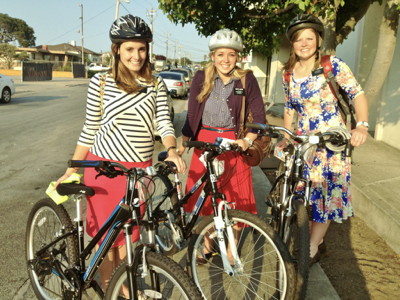

In [ ]:
from ultralytics import YOLO

# Load your trained model
model_path = "/content/extracted_files/yolo/yolov8m_imgsz800_ep20/weights/best.pt"  # adjust to your best.pt path
model = YOLO(model_path)

# Predict on a new image
result = model.predict("/content/helmet_data/images/BikesHelmets2.png", save=True)

# (Optional) Show prediction
from IPython.display import Image
Image(filename='/content/helmet_data/images/BikesHelmets2.png')  # YOLO saves prediction to /runs/detect/predict/


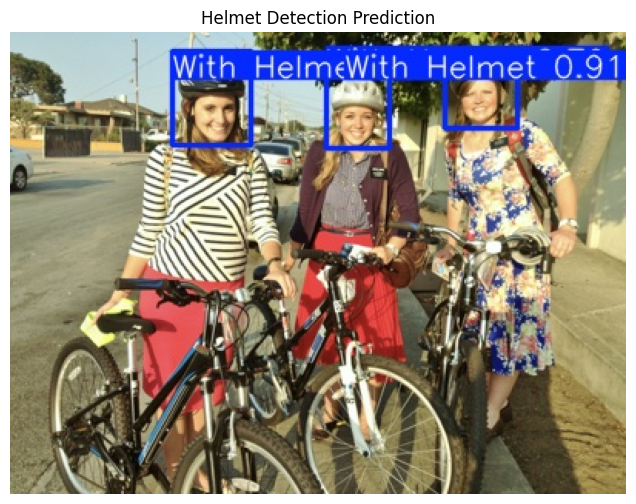

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and display the result image
result_img_path = '/content/runs/detect/predict/BikesHelmets2.jpg'
img = Image.open(result_img_path)

plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.title('Helmet Detection Prediction')
plt.show()


In [ ]:
# Get the first image's detection result
boxes = result[0].boxes

# If no detections
if boxes is None or boxes.cls.numel() == 0:
    print("❌ No objects detected.")
else:
    # Convert to numpy
    class_ids = boxes.cls.cpu().numpy().astype(int)
    confidences = boxes.conf.cpu().numpy()
    bboxes = boxes.xyxy.cpu().numpy()  # (x1, y1, x2, y2) format

    # Print detections
    for cls_id, conf, bbox in zip(class_ids, confidences, bboxes):
        label = result[0].names[int(cls_id)]
        print(f"🔹 Detected {label} with confidence {conf:.2f} at {bbox}")

    # Check if Helmet is present
    if 0 in class_ids:
        print(f"\n✅ Helmet detected {list(class_ids).count(0)} times!")
    else:
        print("\n❌ No Helmet detected.")


🔹 Detected With Helmet with confidence 0.91 at [     282.93       12.52      329.58      62.597]
🔹 Detected With Helmet with confidence 0.90 at [     105.95      12.253      156.88       73.91]
🔹 Detected With Helmet with confidence 0.79 at [     205.43      27.161      246.35      75.226]

✅ Helmet detected 3 times!


In [ ]:
result

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'With Helmet'}
 obb: None
 orig_img: array([[[211, 206, 180],
         [212, 208, 181],
         [211, 208, 179],
         ...,
         [114, 188, 203],
         [106, 173, 190],
         [109, 175, 192]],
 
        [[213, 208, 182],
         [212, 208, 180],
         [212, 207, 180],
         ...,
         [114, 184, 200],
         [101, 174, 186],
         [ 96, 171, 181]],
 
        [[212, 209, 182],
         [212, 209, 182],
         [212, 209, 182],
         ...,
         [106, 175, 192],
         [ 90, 163, 174],
         [ 89, 163, 170]],
 
        ...,
 
        [[103, 134, 133],
         [113, 147, 147],
         [ 92, 130, 131],
         ...,
         [ 68, 129, 149],
         [ 70, 131, 149],
         [ 66, 127, 144]],
 
        [[113, 146, 148],
         [101, 136, 138],
         [ 85, 125, 127],
         ...,
         [ 60